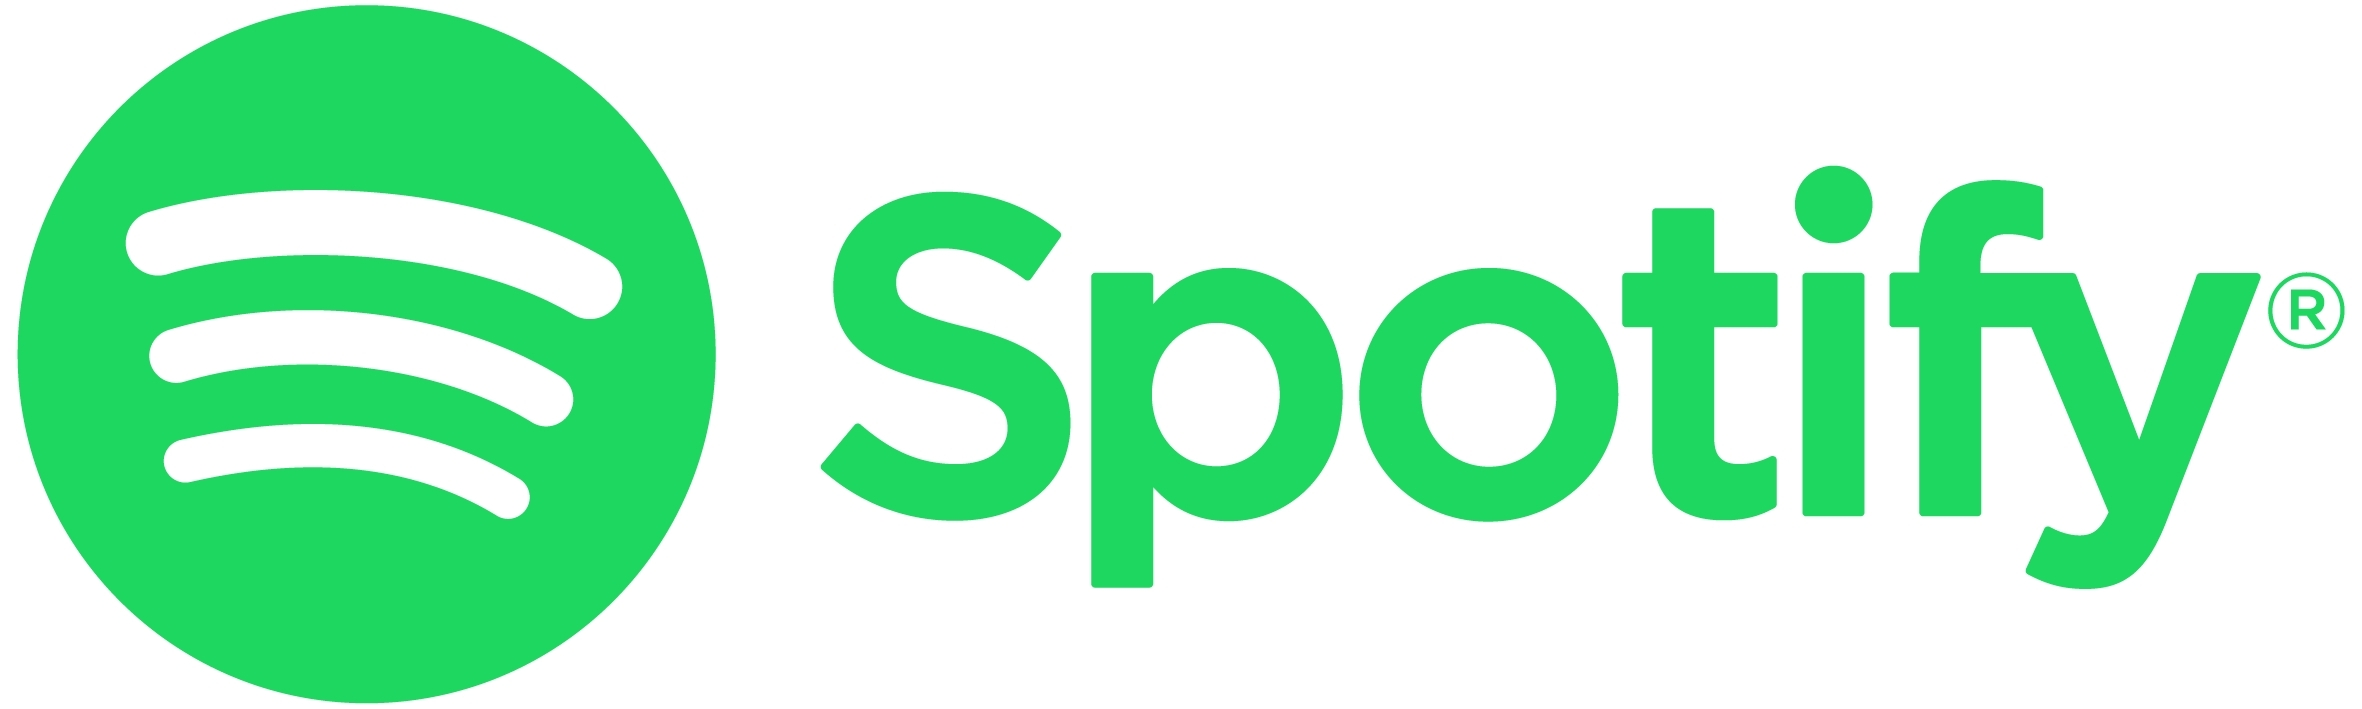

## Summary

In this study, various visualizations, inferences, clustering analyzes, classification models and two applications were developed with spotify data. 

First of all, the data on the playlist basis were grouped according to the songs and then outlier analysis was performed. Then, categorical variables were visualized and inferences were made on them. 

By using 3 clustering methods, the most successful model was found by visualizing after dimension reduction with PCA method. Then, 50 classes were created with the K-Means method, which is the most successful model. The cluster was estimated by connecting the entered song name to the spotify API and pulling the necessary values to be predicted. Then a playlist was created from the 50 most popular songs in this cluster. 

For the classification problem, some variables were transformed into categorical variables. After the target variable was created, the dataset was updated with an unbalanced data approach. Afterwards, the most successful one among the 6 classification models was selected and this model was optimized by manually entering the parameters. The success metric was not only the accuracy value, but also the confusion matrix and precision and recall were also taken into account. The most successful model has been the LGBM model. 

After the model is developed, Will Song be Hit ? application has been developed. In this application, the artist can predict how likely the song will be successful or unsuccessful by entering the values of the music into the model before composing the song. In addition, to inspire the singer, the clustering model creates a playlist of 50 songs similar to the entered values.

# Feature Explanations

- duration_ms: The duration of the track in milliseconds.

- key: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

- mode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- time_signature: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

- danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

- energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. 

- instrumentalness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

- speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music.Values below 0.33 most likely represent music and other non-speech-like tracks.

- valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 

- song_popularity: Song ratings of spotify audience.

- liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

## Data and Packages

In [2]:
# Dataframe, Statistics
import pandas as pd
import numpy as np
from scipy import stats

# Visualization Tools
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

# Machine Learning
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
import lightgbm as lgb
import xgboost as xgb

# Dimension Reduction
from sklearn.decomposition import PCA

# Spotify API
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import json

# Others
import requests
import webbrowser
import pickle
import re

df = pd.read_csv('norette.csv',index_col=[0])
df['track_uri'] = df['track_uri'].str.replace('spotify:track:', '', regex=False)


## Functions

In [3]:
def catch_outliers(df,threshold):
    df = df.copy()
    numericdata = df.select_dtypes(include=np.number)
    #Get the z-score for specified threshold
    threshold_z_score = stats.norm.ppf(threshold)
    
    # Get the z-scores for each value in df
    z_score_df = pd.DataFrame(stats.zscore(numericdata),columns=numericdata.columns)
    
    # Return the count of outliers in each column, and compare then to the threshold
    
    return (z_score_df > threshold_z_score).sum(axis=0)

def remove_outliers(df,threshold):
    df = df.copy()
    numericdata = df.select_dtypes(include=np.number)
    #Get the z-score for specified threshold
    threshold_z_score = stats.norm.ppf(threshold)
    
    # Get the z-scores for each value in df
    z_score_df = pd.DataFrame(stats.zscore(numericdata),columns=numericdata.columns)
    z_score_df = z_score_df > threshold_z_score
    
    # Get indices of the outliers
    outliers = z_score_df.sum(axis=1)
    outliers = outliers>0
    outlier_indices = df.index[outliers]
    
    # Drop outlier examples
    df = df.drop(outlier_indices,axis=0).reset_index(drop=True)
    
    return df

def cat_plot(variable,data,palette=px.colors.qualitative.Light24):
    # What tone are the songs usually made in?
    fig =px.histogram(data,x=variable,color=variable,
                      color_discrete_sequence=palette)
    fig.update_layout(bargap=0.2)
    fig.show()

def create_similar_songs_pl(token,cluster,data,username='11143699684'):
    
    spotifyObject = spotipy.Spotify(auth=token)
    
    # Create empty playlist
    spotifyObject.user_playlist_create(user=username,name=f"Cluster-{cluster}")
    # Get id of playlist
    pl = spotifyObject.user_playlists(user=username)
    # Get id of latest playlist
    playlist = pl['items'][0]['id']
    
    
    plist = data[data['cluster_label']==cluster]
    plist = plist.sort_values('song_popularity',ascending=False).iloc[:50].reset_index(drop=True)
  
    list_of_tracks = [('spotify:track:'+t) for t in plist['track_id']]
    # Add tracks to empty playlist
    spotifyObject.user_playlist_add_tracks(user=username,playlist_id = playlist,tracks=list_of_tracks)
    print('Playlist generated')
    webbrowser.open_new_tab(spotifyObject.user_playlists(user=username)['items'][0]['external_urls']['spotify'])
   
    
def create_playlist(p_name,name,model,data,token,username='11143699684'):

    # Connecting to API
    spotifyObject = spotipy.Spotify(auth=token)

    
    # Create empty playlist
    spotifyObject.user_playlist_create(user=username,name=p_name)
    # Get id of playlist
    pl = spotifyObject.user_playlists(user=username)
    playlist = pl['items'][0]['id']
    
    results = spotifyObject.audio_features(spotifyObject.search(name)['tracks']['items'][0]['uri'])[0]
    resdata = pd.DataFrame(results,index=[0])
    resdata = resdata.drop(['id','uri','type','key','mode','track_href','analysis_url','time_signature', 'isrc'],axis=1)
    
    cluster = model.predict(resdata)[0]
    plist = data[data['cluster_label']==cluster]
    plist = plist.sort_values('song_popularity',ascending=False).iloc[:50].reset_index(drop=True)
    
    # Get track id of songs
    list_of_tracks = [('spotify:track:'+t) for t in plist['track_id']]
    # Add tracks to empty playlist
    spotifyObject.user_playlist_add_tracks(user=username,playlist_id = playlist,tracks=list_of_tracks)
    print('Playlist generated')
    webbrowser.open_new_tab(spotifyObject.user_playlists(user=username)['items'][0]['external_urls']['spotify'])
    
    
def print_score(clf, X_train, y_train, X_test, y_test):

    print("Test Sonuçları:\n")        
    print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
    print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test),digits=4)))
    print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))

        
def withthreshold(clf, X_train, y_train, X_test, y_test,threshold):
    print("Test Sonuçları:\n")        
    print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, (clf.predict_proba(X_test)[:,1] >= threshold).astype(int))))
    print("Classification Report: \n {}\n".format(classification_report(y_test, (clf.predict_proba(X_test)[:,1] >= threshold).astype(int),digits=4)))
    print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, (clf.predict_proba(X_test)[:,1] >= threshold).astype(int))))
    
    
def conf(model):
    f,ax = plt.subplots(figsize=(6,6))

    sns.heatmap(confusion_matrix(y_test,model.predict(X_test)), annot=True,cmap="Greens", fmt= '.0f',
                ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
    plt.xlabel("Predicted Label")
    plt.xticks(size = 12)
    plt.yticks(size = 12, rotation = 0)
    plt.ylabel("True Label")
    plt.title("Confusion Matrix", size = 12)

    plt.show()

def get_percs(model,y_valid,X_valid):
    dicto = {}
    son = pd.DataFrame()
    for i in range (60,95,1):
        threshold = i/100
        cr = classification_report(y_valid, (model.predict_proba(X_valid)[:,1] >= threshold).astype(int),digits=4)
        cr = cr.replace('  ','')
        yuzde = "%"+"{:.2f}".format(float(find_between_r(cr,'\n 1 ','')[:6])*100)
        dicto = {'Thresh' :i, 'Yüzde':yuzde}
        son = son.append(pd.DataFrame(dicto,index=[0]),ignore_index=True)
    return son

def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""
    
def bestmodel(X_train,y_train,X_valid,y_valid):
    from sklearn.linear_model import LogisticRegression
    loj = LogisticRegression(solver = "liblinear")
    loj_model = loj.fit(X_train,y_train)
    #knn = KNeighborsClassifier()
    #knn_model = knn.fit(X_train, y_train)
    #svc_model = SVC(kernel = "rbf").fit(X_train, y_train)
    #svm_model = SVC(kernel = "linear").fit(X_train, y_train)
    from sklearn.neural_network import MLPClassifier
    mlpc = MLPClassifier().fit(X_train, y_train)
    from sklearn.tree import DecisionTreeClassifier
    cart = DecisionTreeClassifier()
    cart_model = cart.fit(X_train, y_train)
    from sklearn.ensemble import RandomForestClassifier
    rf_model = RandomForestClassifier().fit(X_train, y_train)
    from sklearn.ensemble import GradientBoostingClassifier
    gbm_model = GradientBoostingClassifier().fit(X_train, y_train)
    #from xgboost import XGBClassifier
    #xgb_model = XGBClassifier().fit(X_train, y_train)
    from lightgbm import LGBMClassifier
    lgbm_model = LGBMClassifier().fit(X_train, y_train)
    modeller = [
        loj_model,
        #knn_model,
        #svm_model,
        #svc_model,
        mlpc,
        cart_model,
        rf_model,
        gbm_model,
        #xgb_model,
        lgbm_model,
    ]
    bas=0
    best_model = loj_model
    for model in modeller:
        isimler = model.__class__.__name__
        y_pred = model.predict(X_valid)
        dogruluk = accuracy_score(y_valid, y_pred)
        print("-"*28)
        print(isimler + ":" )
        print("Accuracy: {:.4%}".format(dogruluk))
        if dogruluk>bas:
            bas = dogruluk
            best_model = model
    print(f'{best_model} : Accuracy : {accuracy_score(y_valid,best_model.predict(X_valid))}')
    return modeller

def will_song_be_hit(classification_model,
                     clustering_model,
                     label_encoder,
                     cluster_data,
                     token,
                     username='11143699684'):
    
    # Cols for predict data
    
    ind_cols =['genres',
                 'mode',
                 'key',
                 'time_signature',
                 'danceability',
                 'energy',
                 'loudness',
                 'speechiness',
                 'acousticness',
                 'instrumentalness',
                 'liveness',
                 'valence',
                 'tempo',
                 'duration_ms']
    
    # Information to user
    
    info = ['','0 or 1', '0-11 (include)','3-7 (include)',
            '0-1 float','0-1 float',
            '-40, 0 float','0-1 float',
            '0-1 float','0-1 float',
            '0-1 float','0-1 float','','']
    
    datas = []
    while True:
        for i in range(len(ind_cols)):
            data = input(f"Enter a {ind_cols[i]} value {info[i]}:")
            datas.append(data)
        # The data types have been changed as it must be the same as the training set   
        pred_data = pd.DataFrame(np.array([datas]),columns=ind_cols)
        pred_data['genres'] = label_encoder.transform(pred_data['genres'])
        pred_data[['genres','mode','key','time_signature']] = pred_data[['genres','mode','key','time_signature']].astype('category')
        pred_data.iloc[:,4:] = pred_data.iloc[:,4:].astype(float)

        try:
            result = classification_model.predict_proba(pred_data)[0][1]
        except:
            print('Please enter sensible values.')
            continue

        if result < 0.5:
            print(f"Predicted Popularity : {result} \n Your song may not be hit.")

            answ = input('Do you want to see similar songs? (y/n)')
            if answ == 'y':
                cluster = clustering_model.predict(pred_data.iloc[:,4:])[0]
                create_similar_songs_pl(token=token,cluster=cluster,data=cluster_data,username=username)
                break
            elif answ == 'n':
                print('Goodbye!')
                break

            else:
                print('Incorrect value! Please try again. ')
                continue

        else:
            print(f"Predicted Popularity : {result} \n Your song may be hit.")

            answ = input('Do you want to see similar songs? (y/n)')
            if answ == 'y':
                cluster = clustering_model.predict(pred_data.iloc[:,4:])[0]
                create_similar_songs_pl(token=token,cluster=cluster,data=cluster_data,username=username)
                break
            elif answ == 'n':
                print('Goodbye!')
                break
            else:
                print('Incorrect value! Please try again.')
                continue

## Data Preprocessing

In [4]:
# To reduce the number of genres, we include only the genre before the comma.
df.genres = df.genres.str.split(',',expand=True)[0]
# Converting 'date' column to datetime data type
df.date = pd.to_datetime(df.date)
# Converting key,mode and time_signature variables, which are actually classes, to categorical variable types.

# 'key' variable is actually the tone of the song. 0=C, 1=C#, 2=D, 3=D#, 4=E, 5=F, 6=F#, 7=G, 8=G#, 9=A, 10=A#, 11=B

# 'mode' is actually the scale type of the song. Major is represented by 1 and minor is 0.

# 'time_signature' is the measure of the song. x>=3 or <=7. x/4 https://en.wikipedia.org/wiki/Time_signature

df = df[(df['time_signature']>=3) & (df['time_signature']<=7)]
#cat_features=['key','mode','time_signature']
#df[cat_features] = df[cat_features].astype("category")

# There is an incorrect data entered into the song_popularity variable here. Let's get rid of this.
df = df[df['song_popularity'] != 'southern hip hop"']

# Converting the song_popularity variable to a numeric variable
df['song_popularity'] = df['song_popularity'].astype(int)

# Let's get rid of data that will not be used in modeling and visualization.
unnec_cols = ['artist_uris','album_uri','album_artist_uris', 'album_img_url','track_preview_url', 'disc_number', 'track_number', 'Track Duration (ms)']
df = df.drop(unnec_cols,axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 564 entries, 0 to 599
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   track_uri           564 non-null    object        
 1   track_name          564 non-null    object        
 2   album_artist_names  564 non-null    object        
 3   album_date          564 non-null    object        
 4   explicit            564 non-null    bool          
 5   isrc                564 non-null    object        
 6   artists_id          564 non-null    object        
 7   album_name          564 non-null    object        
 8   artist_name_s       564 non-null    object        
 9   date                564 non-null    datetime64[ns]
 10  duration_ms         564 non-null    float64       
 11  song_popularity     564 non-null    int64         
 12  added_by            564 non-null    object        
 13  added_at            564 non-null    object        
 14 

### Generating Song Data

In [25]:
df.isna().count()

track_uri             564
track_name            564
album_artist_names    564
album_date            564
explicit              564
isrc                  564
artists_id            564
album_name            564
artist_name_s         564
date                  564
duration_ms           564
song_popularity       564
added_by              564
added_at              564
genres                564
danceability          564
energy                564
key                   564
loudness              564
mode                  564
speechiness           564
acousticness          564
instrumentalness      564
liveness              564
valence               564
tempo                 564
time_signature        564
dtype: int64

In [9]:
# Just to work on songs let's group by songs.
songdata = df.groupby(['track_name','artist_name_s','genres','mode','key','time_signature','track_uri']).mean().reset_index()
songdata.head()

TypeError: agg function failed [how->mean,dtype->object]

In [7]:
#songdata = df
cat_features=['key','mode','time_signature']
songdata[cat_features] = songdata[cat_features].astype("category")
songdata.info()

NameError: name 'songdata' is not defined

### Distribution of Numeric Features

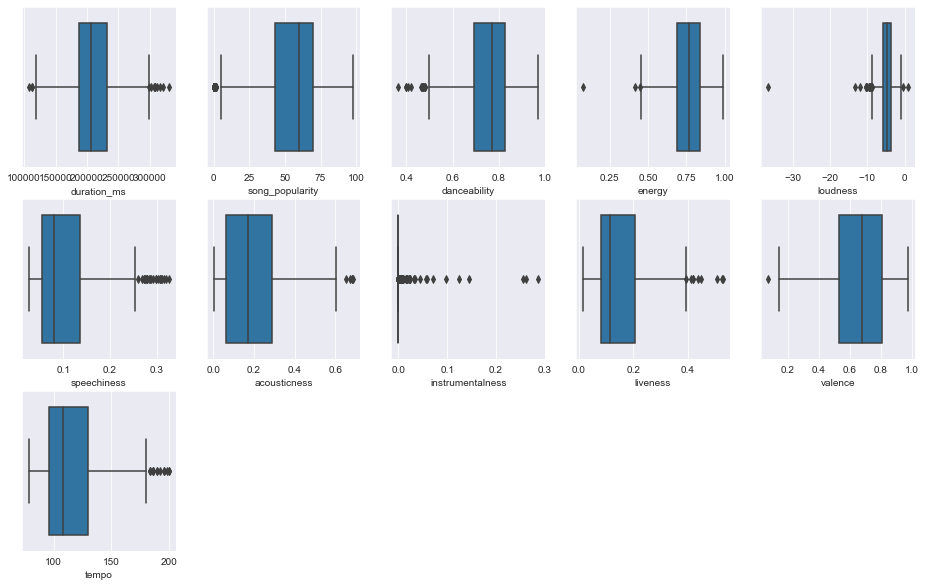

In [ ]:
#Creating subplots with boxplots to observe the distributions of variables and outliers
numericdata = songdata.select_dtypes(include=np.number)

plt.figure(figsize=(16,10))

for i in range(len(numericdata.columns)):
    plt.subplot(3,5,i+1)
    sns.boxplot(numericdata[numericdata.columns[i]])

plt.show()

According to the chart above, outliers can be observed in more than one variable. To deal with these outliers, instead of using the IQR method (i.e. only getting the data inside the rectangle in the box plot), we will convert the data into Z values using the standard normal distribution. In this way, we will not drop too much data. For this, let's use the remove_outliers function that we defined earlier.

## Outlier Detection

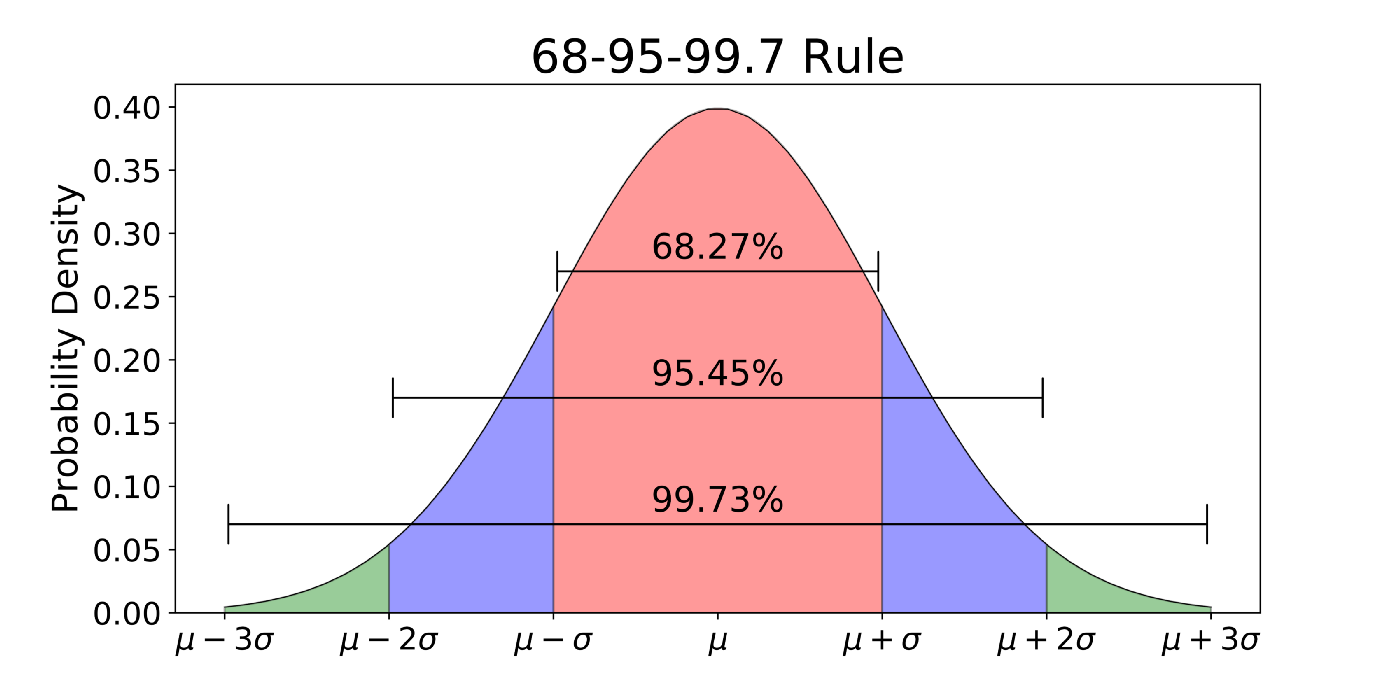

The threshold parameter that we will give to this function means that we will ignore the values outside the threshold ranges as seen in the image above.

### How much data will we lose?

In [ ]:
catch_outliers(songdata,0.6827)

duration_ms         130
song_popularity     225
danceability        205
energy              193
loudness            166
speechiness         136
acousticness        153
instrumentalness     22
liveness            135
valence             207
tempo               127
dtype: int64

In [ ]:
catch_outliers(songdata,0.9545)

duration_ms         27
song_popularity      1
danceability         7
energy              16
loudness             3
speechiness         43
acousticness        41
instrumentalness    17
liveness            27
valence              0
tempo               67
dtype: int64

In [ ]:
catch_outliers(songdata,0.9973)

duration_ms          3
song_popularity      0
danceability         0
energy               0
loudness             0
speechiness         12
acousticness         5
instrumentalness     7
liveness             5
valence              0
tempo                3
dtype: int64

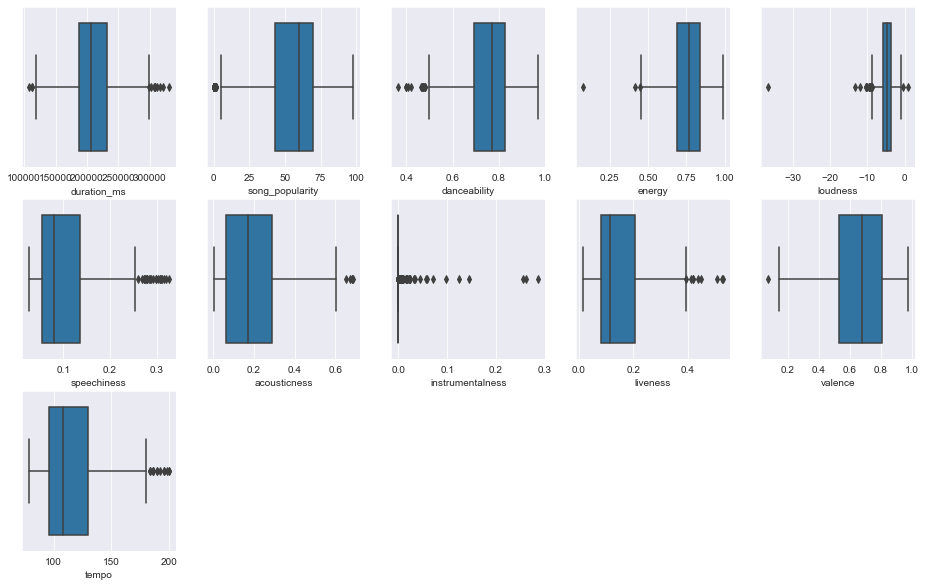

In [ ]:
# Since we did not want to sacrifice too much data, 
# we preferred to use data in a standard normal distribution range of 99.73%.

songdata = remove_outliers(songdata,0.9973)

numericdata = songdata.select_dtypes(np.number)

plt.figure(figsize=(16,10))

for i in range(len(numericdata.columns)):
    plt.subplot(3,5,i+1)
    sns.boxplot(numericdata[numericdata.columns[i]])

plt.show()

Let's interpret the graph above. We got rid of the extra outliers in duration_ms, liveness, speechiness, variables. At the same time, we eliminated the rare outliers in the tempo and loudness columns. At the same time, the variables of rank, speechiness, acousticness, liveness have a right-skewed distribution. For these, we can say that the median is lower than the mean. The opposite is true for loudness and song_popularity variables. We can say that the measure of central tendency to represent these variables is the median, not the mean. The remaining variables such as artist_popularity, danceability, energy, valence, tempo and duration_ms are normally distributed.

## Data Understanding by Visualization and EDA

In this section, various visualizations have been made for the data we have and these have been interpreted.

### What is the relationship between the variables?

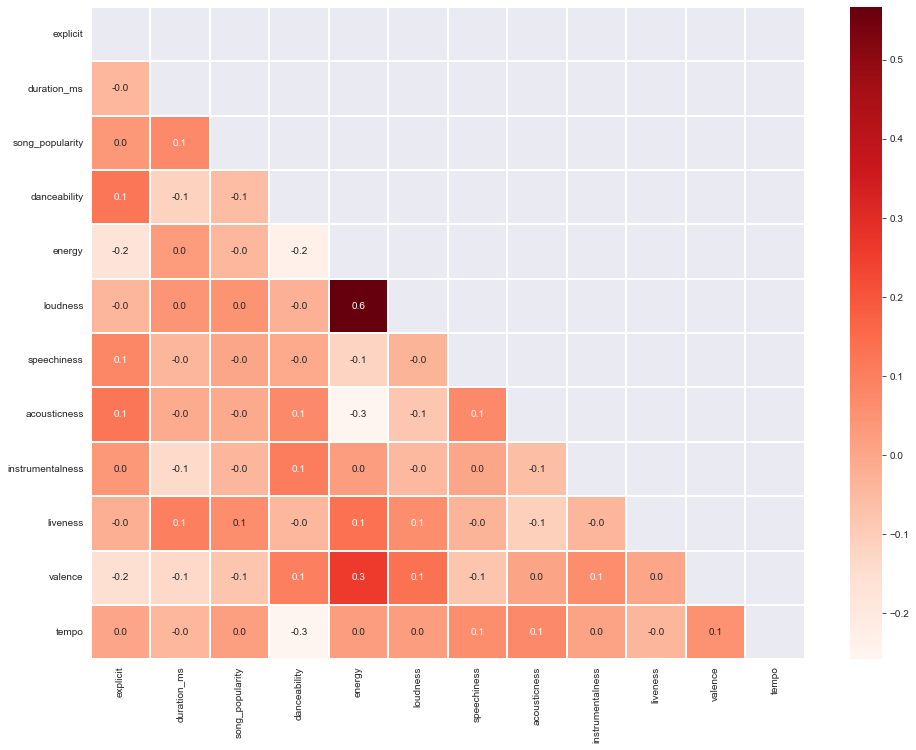

In [ ]:
f,ax = plt.subplots(figsize=(16, 12))
# Correlation matrix
matrix = songdata.corr()
# We create mask to see their values on the graph only once.
mask = np.triu(np.ones_like(matrix,dtype=bool))
sns.heatmap(songdata.corr(), annot=True, linewidths=0.4,linecolor="white", fmt= '.1f',ax=ax,cmap="Reds",mask=mask)
plt.show() 

When we examine the heatmap containing the correlation matrix, we see that there is a high positive correlation between energy and loudness. energy/valence, danceability/valence, and speechiness/danceability are also positively correlated. There is a negative high correlation between energy and acousticness. There is also a negative relationship between loudness and acousticness.

### Categorical Variable Analysis

In [ ]:
# What tone are the songs usually made in?
cat_plot('key',songdata)

I said above which key value corresponds to which musical note. Accordingly, the least tone used in songs is the E tone. On the other hand, the most used tone is the C# tone.

In [ ]:
#keylist =['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

In [ ]:
# What kind of key are the songs usually made with?
cat_plot('mode',songdata,px.colors.qualitative.Safe)

We already knew that a mode variable of 1 means the song has a major key, and minor key is 0. Looking at the chart above, we can say that most of the songs have a major key.

In [ ]:
# What is the measure of the songs

# 3 is 3/4, 4 is 4/4, 5 is 5/4
cat_plot('time_signature',songdata,px.colors.qualitative.Pastel)

It is general information that the songs have a 4/4 measure. We can observe that this general information is also valid in this data set.

### Does the tone of the song affect its popularity?

In [ ]:
fig = px.bar(songdata.groupby('key').median().reset_index(),
             x='key',
             y='song_popularity',
             color='key',
             color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_xaxes(tickangle=45)
fig.show()

Answer is no. We see in the chart that the tones of the songs have no effect on popularity.

### Does the mode of the song affect its popularity?

In [ ]:
fig = px.bar(songdata.groupby('mode').median().reset_index(),
             x='mode',
             y='song_popularity',
             color='mode',
             color_discrete_sequence=px.colors.qualitative.Pastel_r)
fig.update_xaxes(tickangle=45)
fig.show()

We can see that the mode variable also has no effect on popularity.

### Does the time_signature of the song affect its popularity?

In [ ]:
fig = px.bar(songdata.groupby('time_signature').median().reset_index(),
             x='time_signature',
             y='song_popularity',
             color='time_signature',
             color_discrete_sequence=px.colors.qualitative.Vivid)
fig.update_xaxes(tickangle=60)
fig.show()

Here we can see that although the count is less than 4, the most popular measure is 5.

### People like Happy Songs or Sad Songs ?

As we see in the feature explanations, audio valance describes the musical positiveness conveyed by a track (like sad or happiness - between 0 to 1). We supposed our threshold is 0.5.

In [ ]:
valence_data = songdata.copy()
valence_data['valence'] = np.where(songdata['valence']>=0.5,'Happy','Sad')

fig = px.bar(valence_data.groupby('valence').median().reset_index(),
             x='valence',
             y='song_popularity',
             color='valence',
             color_discrete_sequence=px.colors.qualitative.Antique)
fig.update_xaxes(tickangle=60)
fig.show()

There is no difference between the popularity of sad songs and happy songs

### Characteristics of Different Genres

In [ ]:
# 5 genres with the highest frequency
songdata['genres'].value_counts().head(5).index.tolist()

['reggaeton',
 'latin hip hop',
 'flamenco urbano',
 'electro latino',
 'urbano espanol']

In [ ]:
# Let's take a look at the valence, energy, danceability, 
# and acousticness characteristics of the 10 genres with the most frequency.
genres_data = songdata.groupby('genres').median().reset_index()

top10genres = genres_data[genres_data['genres'].str.
                          fullmatch('|'.join(songdata['genres'].
                          value_counts().head(5).index.tolist()))]

fig = px.bar(top10genres,x='genres',y=['valence','energy','danceability','acousticness'],barmode='group')
fig.update_xaxes(tickangle=45)
fig.show()

When we examine the 5 most common genres according to their valence, energy, danceability and acousticness variables, we see that there is not much difference between these genres. Acousticness value is higher in francoton type than others. The variable with the highest value in the K-pop genre is the energy variable. The highest danceability values are observed in dutch hip hop and francoton genres.

### Average Time of Genres

In [ ]:
# How different are the durations of the song types?

fig = px.box(songdata[songdata['genres'].str.
                    fullmatch('|'.join(songdata['genres'].
                    value_counts().head(10).index.tolist()))],y='duration_ms',color='genres')
fig.update_xaxes(tickangle=45)
fig.show()

If we interpret the graph except for the outliers, we can say that the song genre with the longest duration is the latin genre. The genres that show the most variation on the basis of time are csk hip hop and francoton.

# Clustering Songs with Different Algorithms


This section focuses on the clustering of songs. Three different clustering methods were used here. At the same time, the PCA approach is used for dimension reduction for ease of visualization.

### How many different clusters should we create?

In [ ]:
X = songdata.select_dtypes(np.number)
X = X.drop(['song_popularity'],axis=1)

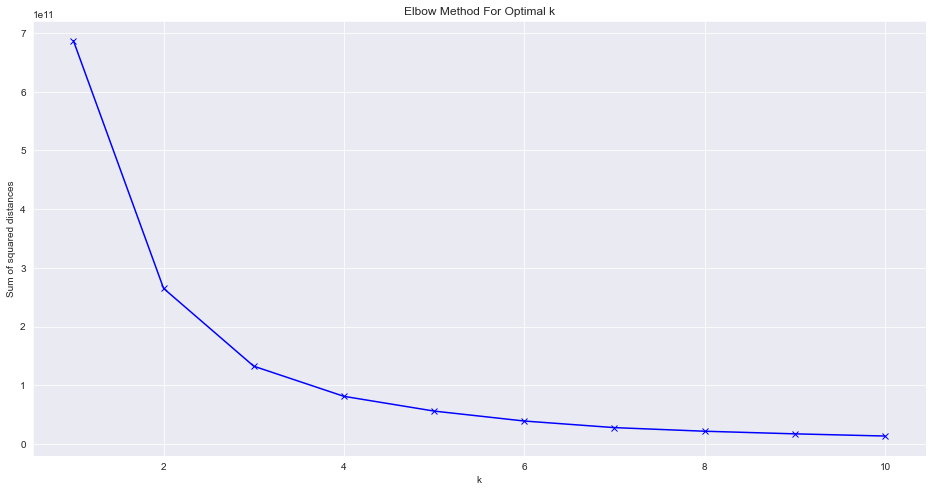

In [ ]:
plt.figure(figsize=(16,8))
ss_dist = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    ss_dist.append(km.inertia_)
plt.plot(K, ss_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow method was used to find the optimal k value above. According to this method, the number of classes in which the data will be clustered should be three. Now, let's create three separate classes for all three methods, visualize them using the PCA method, and decide which method is more successful.

### GaussianMixture

We need to reduce the dimension of independent variables to 2 dimension so that the clusters can be easily visualized. We will use the PCA approach for this.

In [ ]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('gaussianmixture', GaussianMixture(n_components=3))
                                 ], verbose=False)
X = songdata.select_dtypes(np.number)
X = X.drop(['song_popularity'],axis=1)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)


pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['track_name'] = songdata['track_name']
projection['cluster'] = song_cluster_labels

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'track_name'])
fig.show()

### K-Means

In [ ]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=3,init='k-means++'))
                                 ], verbose=False)
X = songdata.select_dtypes(np.number)
X = X.drop(['song_popularity'],axis=1)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)


pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['track_name'] = songdata['track_name']
projection['cluster'] = song_cluster_labels

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'track_name'])
fig.show()

### Mini-Batch K-Means

In [ ]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('mini-batch-k-means', MiniBatchKMeans(n_clusters=3))
                                 ], verbose=False)
X = songdata.select_dtypes(np.number)
X = X.drop(['song_popularity'],axis=1)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)


pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['track_name'] = songdata['track_name']
projection['cluster'] = song_cluster_labels

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'track_name'])
fig.show()

## Playlist Generator App

According to the graphs above, the most successful algorithm seems to be the K-Means algorithm. Now we will create 30 different classes using the K-Means algorithm. Then, we will create a playlist with 50 of the most popular songs in the set containing that song, according to the song and artist values from the user.

### Create Classes

In [ ]:
%%time
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=50,init='k-means++'))
                                 ], verbose=False)
X = songdata.select_dtypes(np.number)
X = X.drop(['song_popularity'],axis=1)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
c_data = songdata.copy()
c_data['cluster_label'] = song_cluster_labels

CPU times: user 702 ms, sys: 285 ms, total: 987 ms
Wall time: 252 ms


In [ ]:
# Save labeled date
c_data.to_csv('c_data.csv')

In [ ]:
# Save the model
pickle.dump(song_cluster_pipeline,open('clustering_model.sav','wb'))

### Create Playlist

You can get your token here: https://developer.spotify.com/console/post-playlists/

In [ ]:
# Spotify API token
token = '6961fb21409e4fac80ac326ed90894d3 ef344f7a8f6543e08aa94fae0ce61753BQAopsAfjpIgtz_Qc6liAuShGCMs1PyMWGNxZpH8hO11YFPVLLGXOpL5rTAQ93Gj3lPNiFgz8wKSXR5ILXKU554VdmfnNTu4xhHwgnu310sJdoZ67IE'
# Spotify ID
username = 'cristinatuduri'
# Connecting to API
spotifyObject = spotipy.Spotify(auth=token)

In [ ]:
#playlist_name = "model"
#search = 'die for you valorant'
#create_playlist(playlist_name,search,model=song_cluster_pipeline,data=c_data,token=token,username=username)

# Classification of Songs with Different Algorithms

In this section, a model will be developed to classify whether songs are hits or not. If the song_popularity variable value is higher than 50, it means Hit, otherwise it means not Hit. At the same time, an application will be developed in this section. In this application, the artist will have an idea about whether it will be a hit by entering the values of the song he will compose, using the model we developed before publishing the song. At the same time, our clustering model will inspire the artist by suggesting songs similar to this artist's song. 

In [ ]:
df_c = songdata.drop(['track_name','album_artist_names','track_uri'],axis=1)

We have removed the variables that will not be used here from our data set. As for why we won't use them, I can say that we removed them because we couldn't access these variables in our live application.

In [ ]:
# We assign the numeric equivalent of the genres variable to the object values
le =LabelEncoder()
df_c['genres'] = le.fit_transform(df_c.genres)
df_c['genres'] = df_c['genres'].astype('category')
# Keeping the label encoder in the local
pickle.dump(le,open('le.sav','wb'))

In [ ]:
# Create the target variable
df_c['target'] = np.where(df_c['song_popularity']>=50,1,0)

### Distribution of the Dependent Variable

In [ ]:
fig =px.histogram(df_c,x='song_popularity',
                  title='Histogram of song_popularity')
fig.update_layout(bargap=0.2)
fig.show()


fig =px.histogram(df_c[df_c['song_popularity']>0],x='song_popularity',
                  title='Histogram of Updated song_popularity')
fig.update_layout(bargap=0.2)
fig.show()


As seen in the graph there are too many popularity values with a value of 0 causing the dataset to be unbalanced. My approach here is, I think the songs with 0 popularity are actually songs that have never been rated, so I'm dropping them from my dataset. In this way, these 0 values will not mislead my model. At the same time, we can see that the updated data set is also normally distributed.

In [ ]:
# Updating the dataset
u_df_c = df_c[df_c['song_popularity']>0]

In [ ]:
fig =px.histogram(df_c,x='target',
                  title='Counts of target',
                 color='target',width=400,height=300)
fig.update_layout(bargap=0.2)
fig.show()
fig =px.histogram(u_df_c,x='target',
                  title='Updated Counts of target',
                 color='target',width=400,height=300)
fig.update_layout(bargap=0.2)

fig.show()


Even though we have updated our data, we can still see that the dataset is unbalanced. Here, we can approach the situation by examining not only accuracy but also confusion matrix as a model metric and considering metrics such as precision and recall.

In [ ]:
len(df_c) - len(u_df_c) , (33212 /len(df_c)) , len(u_df_c)

(68, 66.82494969818913, 429)

The number of data we lost by deleting data with popularity = 0 is 33212, which corresponds to 28% of the total data set. The number of data in the newly formed data set is 86680.

In [ ]:
# Let's create X by dropping the dependent variables
X=u_df_c.drop(['song_popularity','target'],axis=1)
# Create y
y = u_df_c['target']

#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, random_state=1)

In [ ]:
len(X_train)/len(X)

0.6993006993006993

Here we divide the dataset into 3. 70% of the data is train, the remaining 30% is divided by 2, and 15% is validation and 15% is test data set. The reason we split the validation and test set into two is that when training a professional model, the model will learn its errors by looking at the validation set, so the real benchmark should be a data set that it has never seen. So this will be our X_test dataset.

### Comparison of Classification Algorithms

My approach here is to first select the most successful simple model and then optimizing hyperparameters.

In [ ]:
X_train = X_train.select_dtypes(include=['number'])
X_train.describe()

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,209795.723333,0.753153,0.754170,-4.911273,0.107952,0.191380,0.004585,0.152292,0.657507,117.496980
std,36566.046887,0.105549,0.117233,1.789855,0.070769,0.152194,0.028589,0.100175,0.193462,28.000508
min,112729.000000,0.365000,0.447000,-13.353000,0.031000,0.000972,0.000000,0.022500,0.145000,78.293000
25%,187385.250000,0.697500,0.679500,-5.713500,0.054300,0.061125,0.000000,0.083150,0.526500,95.073500
50%,206499.500000,0.771000,0.758500,-4.778500,0.085900,0.172000,0.000002,0.111500,0.680000,106.827000
75%,230917.250000,0.825250,0.843500,-3.697750,0.137750,0.286500,0.000101,0.209250,0.801000,129.962750
max,320357.000000,0.970000,0.976000,0.796000,0.326000,0.653000,0.286000,0.529000,0.974000,199.899000


In [ ]:
# Comparison of six models.
models = bestmodel(X_train,y_train,X_val,y_val)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/cristinatuduripoza/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    nodelist: ListType[stmt],
  File "/var/folders/jz/d746437j2zl10s6kqfxg0s980000gn/T/ipykernel_31713/785359583.py", line 2, in <cell line: 2>
    models = bestmodel(X_train,y_train,X_val,y_val)
  File "/var/folders/jz/d746437j2zl10s6kqfxg0s980000gn/T/ipykernel_31713/2443435271.py", line 152, in bestmodel
    from sklearn.ensemble import RandomForestClassifier
  File "/Users/cristinatuduripoza/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/__init__.py", line 16, in <module>
    from ._gb import GradientBoostingClassifier
  File "/Users/cristinatuduripoza/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 33, in <module>
    from ._gradient_boosting import predict_stages
  File "sklearn/ensemble/_gradient_boosting.pyx", line 1, in init sklearn.ensemble._gradient_boosting
ValueError: skl

In [ ]:
import sklearn
print(sklearn.__version__)


1.0.2


Here we see that the most successful model is LGBM with an accuracy of 84%. Now let's do parameter tests on it

In [ ]:
model = lgb.LGBMClassifier(learning_rate=0.01, seed=8798,num_iterations=500,n_jobs=-1)
model.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)], verbose=50)

lgb.plot_metric(model)

TypeError: fit() got an unexpected keyword argument 'verbose'

In order for the model not to be overfit, the graph was examined and the number of iterations was determined.

In [ ]:
print_score(model,X_train,y_train,X_val,y_val)

Test Sonuçları:

accuracy score: 0.8430

Classification Report: 
               precision    recall  f1-score   support

           0     0.8612    0.9660    0.9106     10668
           1     0.6088    0.2538    0.3583      2226

    accuracy                         0.8430     12894
   macro avg     0.7350    0.6099    0.6344     12894
weighted avg     0.8176    0.8430    0.8152     12894


Confusion Matrix: 
 [[10305   363]
 [ 1661   565]]



In [ ]:
2226/12894

0.17263843648208468

By looking at the confusion matrix we can see what is causing the unbalanced data. The Precision value shows what percentage of the values the model calls 1 are actually 1. It is very difficult to predict the 1 class that only makes up 17% of the data. While the model knows the 0 class 86% correctly, this rate is 61% in the 1 class.

Here we can increase the precision of class 1 by playing with the 0.5 threshold.

In [ ]:
withthreshold(model,X_train,y_train,X_test,y_test,0.7)

Test Sonuçları:

accuracy score: 0.8306

Classification Report: 
               precision    recall  f1-score   support

           0     0.8319    0.9957    0.9064     10713
           1     0.7430    0.0581    0.1078      2289

    accuracy                         0.8306     13002
   macro avg     0.7874    0.5269    0.5071     13002
weighted avg     0.8162    0.8306    0.7658     13002


Confusion Matrix: 
 [[10667    46]
 [ 2156   133]]



We were able to change the threshold of the sigmoid function from 0.5 to 0.74, but there is a trade-off as you can see. The recall value shows us what percentage of that class the model is predicting. We see that while the precision value increases for class 1, the recall value decreases.


We can address this issue as follows. The threshold value we give to the withthreshold function actually filters the predict_proba (prediction probability) value returned by the model. The confusion matrix takes into account the predict_proba value of 0.5. Below 0.5 is class 0, above 0.5 is class 1. 

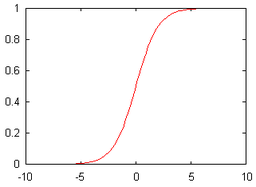


By changing this, we were able to observe precision, recall values. Isn't this also a simulation of the prediction probabilities that the model returns to us? Yes, that's my approach. For example, with what percent probability does the prediction probability that the model says 0.7 actually belong to the class 1? The answer is precision, ie 0.74 (74%). Now let's get the precision values for all predict_proba values from 60 to 95.

In [ ]:
# Generating percentages data
perc_df = get_percs(model,y_val,X_val)
perc_df = perc_df.T.reset_index(drop=True).T.set_index([0]).T.reset_index(drop=True)
perc_df.to_csv('perc_df.csv')

In [ ]:
perc_df

,60,61,62,63,64,65,66,67,68,69,...,85,86,87,88,89,90,91,92,93,94
0,%67.68,%67.93,%68.78,%69.89,%70.09,%69.90,%69.76,%67.94,%67.78,%68.81,...,%75.00,%66.67,%66.67,%100.00,%100.00,%0.00,%0.00,%0.00,%0.00,%0.00


In [ ]:
username ='11143699684'

token = 'BQCraYWTGDp3k83W1BnXaHp8Ol8F1x3eMop7GKA1pIj3XYvD5fN6Crg6cAA3q5gDurl-DKUPYd8_w4HQcaOFVu3QUzUc__VPpgmoDBQ9QeCWV-IhYVDoBvGdKjoJH-uI2jDc1KoOGip4SSRlufrVzRtwq6YTNSfIuEFasM2Msj0avM_slb2_jUY64hhI9pIcXQ__p9pXkSBuEw'

In [ ]:
will_song_be_hit(model,song_cluster_pipeline,le,c_data,token)

Enter a genres value :latin
Enter a mode value 0 or 1:1
Enter a key value 0-11 (include):7
Enter a time_signature value 3-7 (include):4
Enter a danceability value 0-1 float:0.74
Enter a energy value 0-1 float:0.5
Enter a loudness value -40, 0 float:-11
Enter a speechiness value 0-1 float:0.62
Enter a acousticness value 0-1 float:0.11
Enter a instrumentalness value 0-1 float:0.31
Enter a liveness value 0-1 float:0.14
Enter a valence value 0-1 float:0.05
Enter a tempo value :140
Enter a duration_ms value :200000
Predicted Popularity : 0.39540799975877683 
 Your song may not be hit.
Do you want to see similar songs? (y/n)y
Playlist generated
